In [1]:
import os.path

naslib_path = '../../zero_cost/NASLib'
benchmark = 'zc_nasbench201'

In [2]:
from zc_combine.utils.naslib_utils import load_search_space, parse_scores


search_space = load_search_space(naslib_path, benchmark)
dfs = parse_scores(search_space)

In [3]:
dataset = 'cifar10'
proxy = 'zen'
data = dfs[dataset]

In [4]:
import json
import os

new_score_file = 'benchmark--nasbench201--cifar10--0.json'

with open(os.path.join(naslib_path, f'naslib/data/zc_benchmarks/{proxy}', new_score_file), 'r') as f:
    new_data = json.load(f)

In [ ]:
data[f'new_{proxy}'] = data[proxy]

for net_data in new_data:
    mask = data['net'] == net_data['arch']
    data_row = data[mask]
    assert len(data_row) == 1
    data.loc[mask, f'new_{proxy}'] = net_data[proxy]['score']

In [65]:
data[data['new_nwot'] == data['new_nwot'].min()]

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,new_nwot
4,"(4, 4, 1, 2, 1, 1)",10.0,-100000000.0,0.000013,46.343872,0.0,0.0,-100000000.0,78.929459,5.574081e+02,0.316346,0.0,0.0,0.0,-100000000.0,4592,15455.0,-100000000.0
140,"(0, 4, 1, 0, 1, 1)",10.0,-100000000.0,0.000012,9.234112,0.0,0.0,-100000000.0,27.910686,-1.000000e+08,0.073306,0.0,0.0,0.0,-100000000.0,7085,15455.0,-100000000.0
230,"(1, 1, 1, 2, 3, 3)",10.0,-100000000.0,0.000011,52.487872,0.0,0.0,-100000000.0,180.591064,-1.000000e+08,0.372346,0.0,0.0,0.0,-100000000.0,8042,15455.0,-100000000.0
260,"(4, 1, 1, 2, 1, 1)",10.0,-100000000.0,0.000011,45.053632,0.0,0.0,-100000000.0,78.853905,5.587752e+02,0.316346,0.0,0.0,0.0,-100000000.0,11143,15455.0,-100000000.0
283,"(0, 4, 1, 2, 1, 1)",10.0,-100000000.0,0.000010,45.053632,0.0,0.0,-100000000.0,78.915443,5.654678e+02,0.316346,0.0,0.0,0.0,-100000000.0,15273,15455.0,-100000000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15403,"(1, 0, 1, 4, 3, 1)",10.0,-100000000.0,0.000054,13.596352,0.0,0.0,-100000000.0,78.531357,-1.000000e+08,0.101306,0.0,0.0,0.0,-100000000.0,5630,15455.0,-100000000.0
15457,"(1, 1, 1, 4, 2, 1)",10.0,-100000000.0,0.000041,45.053632,0.0,0.0,-100000000.0,78.648895,-1.000000e+08,0.316346,0.0,0.0,0.0,-100000000.0,9338,15455.0,-100000000.0
15459,"(3, 3, 1, 1, 1, 1)",10.0,-100000000.0,0.000048,16.668352,0.0,0.0,-100000000.0,129.824722,5.999489e+02,0.129306,0.0,0.0,0.0,-100000000.0,9612,15455.0,-100000000.0
15566,"(1, 1, 1, 4, 1, 4)",10.0,-100000000.0,0.000046,10.524352,0.0,0.0,-100000000.0,27.677231,-1.000000e+08,0.073306,0.0,0.0,0.0,-100000000.0,14275,15455.0,-100000000.0


In [66]:
ok_data = data[data['new_nwot'] > data['new_nwot'].min()].copy()
ok_data['new_nwot'].min()

587.6903735290828

In [8]:
edge_map = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))
edge_map = {val: i for i, val in enumerate(edge_map)}

def edge(op_list, i, j):
    return op_list[edge_map[(i, j)]]

def zero_outgoing(net):
    for node in [2, 3]:
        inactive = all([(edge(net, i, node) == 1) for i in range(1, node)])
        if not inactive:
            continue
        for j in range(node + 1, 5):
            net[edge_map[(node, j)]] = 1
    return net


def zero_ingoing(net):
    for node in [3, 2]:
        inactive = all([(edge(net, node, j) == 1) for j in range(node + 1, 5)])
        if not inactive:
            continue
        for i in range(1, node):
            net[edge_map[(i, node)]] = 1
    return net


for i, net in enumerate(ok_data['net']):
    net = [int(i) for i in net.strip('()').split(',')]
    net1 = zero_outgoing(net)
    net2 = zero_ingoing(net1)

    net = f"({', '.join([str(i) for i in net2])})"
    idx = ok_data.index[i]
    ok_data.loc[idx, 'new_net'] = net

In [9]:
ok_data[ok_data['net'] != ok_data['new_net']][['net', 'new_net']]

,net,new_net
2,"(2, 0, 3, 1, 4, 1)","(2, 1, 3, 1, 4, 1)"
5,"(2, 1, 0, 1, 3, 0)","(2, 1, 0, 1, 3, 1)"
6,"(0, 4, 1, 1, 1, 0)","(1, 4, 1, 1, 1, 0)"
14,"(1, 0, 3, 2, 0, 0)","(1, 0, 3, 1, 1, 0)"
17,"(2, 2, 2, 1, 4, 1)","(2, 1, 2, 1, 4, 1)"
...,...,...
15606,"(4, 0, 0, 1, 1, 2)","(1, 0, 0, 1, 1, 2)"
15607,"(3, 2, 1, 3, 3, 1)","(3, 1, 1, 1, 3, 1)"
15615,"(1, 0, 3, 3, 3, 2)","(1, 0, 3, 1, 1, 2)"
15616,"(2, 4, 3, 4, 1, 1)","(1, 1, 3, 1, 1, 1)"


In [10]:
import pandas as pd

unique_data = []

for net in ok_data['new_net'].unique():
    nets = ok_data[ok_data['new_net'] == net]
    nwots = nets['new_nwot']
    val_accs = nets['val_accs']
    assert len(nets) == 1 or  nwots.std() < 3, nwots.std()
    assert len(nets) == 1 or val_accs.std() < 8, (nets[['net', 'val_accs']], val_accs.std())

    unique_data.append({'net': net, 'val_accs': val_accs.median(), 'new_nwot': nwots.mean(),
                        'acc_std': val_accs.std(), 'nwot_std': nwots.std()})

unique_data = pd.DataFrame(unique_data)

In [11]:
unique_data['nwot_std'].max()

2.892912835664622

In [12]:
ylims = {'nwot': (550, 850)}

def plt_ylim(prox):
    if prox not in ylims:
        return
    plt.ylim(ylims[prox][0], ylims[prox][1])

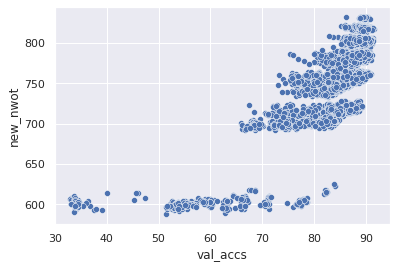

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plot_data = unique_data

sns.scatterplot(data=plot_data, x='val_accs', y='new_nwot')
#plt.xlim(70, 91)
#plt_ylim(proxy)
plt.show()

In [24]:
from zc_combine.operations import parse_ops_nb201, count_all_ops

count_set = {0, 1, 2, 3, 4}
ops = parse_ops_nb201(plot_data)
count_all_ops(plot_data, ops, count_set)

In [25]:
# NB201 op names and edge indices to edges for convenience
OP_NAMES = ["Identity", "Zero", "ReLUConvBN3x3", "ReLUConvBN1x1", "AvgPool1x1"]
OP_NAMES_NB201 = ['skip_connect', 'none', 'nor_conv_3x3', 'nor_conv_1x1', 'avg_pool_3x3']

EDGE_LIST = ((1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4))

## NASWOT bias
NASWOT seems to be highly biased towards the number of convolutions. Let us define `count` == number of `Conv3x3` + number of `Conv1x1` in a cell.

Then, plotting every count (from 1 to 6) as a different colour, we get this:

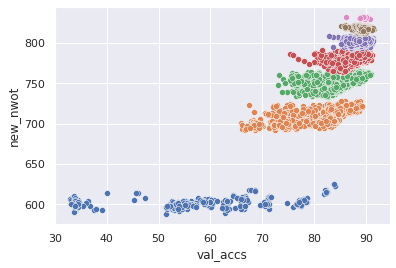

In [26]:
from zc_combine.operations import plot_clouds

plot_clouds(plot_data, (2,3), 'new_nwot', vmax=7)
#plt_ylim(proxy)
plt.show()

In [27]:
def pool_out(net):
    ids = net.strip('()').split(', ')
    count = 0
    for i in [2, 4, 5]:
        if ids[i] == '4':
            count += 1
    return count

plot_data['n_pools'] = [pool_out(n) for n in plot_data['net']]

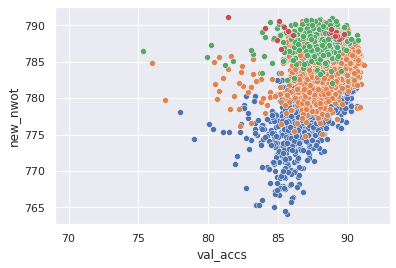

In [62]:
zoom = 3

data_zoom = plot_data[plot_data[str((2, 3))] == zoom]
plot_clouds(data_zoom, data_zoom[str((1,))], 'new_nwot', vmax=7)
plt.xlim(69, 93)
#plt.ylim(700, 820)
plt.show()

In [40]:
# prox idea ... number of pools... where the pools go...

zoomed = data_zoom[data_zoom[str((1,))] == 0]
zoomed = zoomed[zoomed['new_nwot'] < 740]#[zoomed['val_accs'] < 81]
zoomed

,net,val_accs,new_nwot,acc_std,nwot_std,"(1,)","(2,)","(3,)","(4,)","(1, 2)",...,"(0, 1, 3)","(0, 1, 4)","(0, 2, 3)","(0, 2, 4)","(0, 3, 4)","(0, 1, 2, 3)","(0, 1, 2, 4)","(0, 1, 3, 4)","(0, 2, 3, 4)","(0, 1, 2, 3, 4)"
537,"(4, 4, 3, 0, 2, 4)",79.36,739.916559,NaN,NaN,0,1,1,3,1,...,2,4,3,5,5,3,5,5,6,6
1083,"(4, 0, 4, 2, 4, 2)",82.65,738.985879,NaN,NaN,0,2,0,3,2,...,1,4,3,6,4,3,6,4,6,6
1348,"(4, 0, 3, 4, 2, 0)",82.57,738.790570,NaN,NaN,0,1,1,2,1,...,3,4,4,5,5,4,5,5,6,6
1362,"(0, 2, 4, 0, 4, 3)",83.69,736.373295,NaN,NaN,0,1,1,2,1,...,3,4,4,5,5,4,5,5,6,6
1407,"(4, 0, 2, 2, 0, 0)",84.34,739.493263,NaN,NaN,0,2,0,1,2,...,3,4,5,6,4,5,6,4,6,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9142,"(4, 2, 4, 4, 4, 2)",83.73,739.250302,NaN,NaN,0,2,0,4,2,...,0,4,2,6,4,2,6,4,6,6
9203,"(4, 4, 3, 2, 4, 4)",82.15,735.281001,NaN,NaN,0,1,1,4,1,...,1,4,2,5,5,2,5,5,6,6
9269,"(0, 0, 3, 2, 4, 4)",83.57,738.821571,NaN,NaN,0,1,1,2,1,...,3,4,4,5,5,4,5,5,6,6
9321,"(0, 2, 4, 4, 4, 2)",83.46,739.526227,NaN,NaN,0,2,0,3,2,...,1,4,3,6,4,3,6,4,6,6


In [83]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

new_proxy = 'new_nwot'

ops_1 = get_op_array(filter_by_range(data_zoom, new_proxy, 0, 775))
ops_2 = get_op_array(filter_by_range(data_zoom, new_proxy, 775, 800))
#ops_3 = get_op_array(filter_by_range(data_zoom, new_proxy, 780, 810))

In [117]:
filter_by_range(data_zoom, new_proxy, 775, 800)

,net,val_accs,new_nwot,"(2,)","(3,)","(2, 3)","(4,)","(2, 4)","(3, 4)","(2, 3, 4)"
1,"(2, 4, 0, 0, 3, 2)",90.52,785.622961,2,1,3,1,3,2,4
3,"(0, 0, 2, 1, 2, 3)",88.32,788.917398,2,1,3,0,2,1,3
8,"(3, 0, 1, 0, 3, 3)",85.67,788.867168,0,3,3,0,0,3,3
18,"(0, 2, 0, 0, 2, 3)",90.56,784.646428,2,1,3,0,2,1,3
20,"(3, 3, 2, 0, 4, 4)",87.83,783.077136,1,2,3,2,3,4,5
...,...,...,...,...,...,...,...,...,...,...
9424,"(0, 3, 2, 3, 1, 4)",87.83,782.911382,1,2,3,1,2,3,4
9427,"(3, 1, 4, 2, 4, 2)",87.22,785.267706,2,1,3,2,4,3,5
9433,"(2, 4, 1, 1, 2, 2)",88.16,787.249921,3,0,3,1,4,1,4
9437,"(2, 1, 4, 2, 3, 0)",88.29,782.715185,2,1,3,1,3,2,4


In [113]:
np.unique(ops_1.flatten(), return_counts=True)[1] / (ops_1.shape[0] * ops_1.shape[1])

array([0.17996454, 0.00088652, 0.2606383 , 0.2393617 , 0.31914894])

In [114]:
np.unique(ops_2.flatten(), return_counts=True)[1]/ (ops_2.shape[0] * ops_2.shape[1])

array([0.19639266, 0.11708145, 0.24924585, 0.25075415, 0.18652589])

In [85]:
np.unique(ops_1[:, 0]), np.unique(ops_1[:, 1])

(array([0, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [86]:
np.unique(ops_2[:, 0]), np.unique(ops_2[:, 1])

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In [80]:
np.unique(ops_3[:, 0]), np.unique(ops_3[:, 1])

(array([0, 1, 2, 3, 4]), array([0, 1, 2, 3, 4]))

In the middle cluster, there are no nets with the same property as nets from the lower cluster.

In [109]:
any((ops_2[:,0] == 1) & (ops_2[:,1] == 1))

False

However, in the upper cluser, there are some nets with the same property as in the middle cluster (meaning that connection (1,2) is turned off).

In [71]:
any((ops_3[:,0] == 1) & (ops_3[:,1] == 1)), any((ops_3[:,0] == 1))

(False, True)

The difference is that these networks never have connections (1,4) or (3,4) turned off. If they were turned off, the network would essentially be shallower.

In [88]:
ops_3_irregular = ops_3[ops_3[:,0] == 1]
any(ops_3_irregular[:,5] == 1), any(ops_3_irregular[:, 2] == 1)

(False, False)

There is also no overlap with the middle cluster - there are no networks with connections (2,3) or (2,4) turned off.

In [104]:
any((ops_2[:,3] == 1)), any((ops_2[:,4] == 1))

(False, False)

In [105]:
for arr in [ops_1, ops_2, ops_3]:
    for i in range(2, ops_1.shape[1]):
        assert np.unique(arr[:, i]).shape[0] > 1

In [112]:
filter_by_range(data_zoom, proxy, 740, 780)

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
391,"(1, 2, 0, 3, 2, 3)",89.97,1602.315016,0.021295,88.307392,8.041321,1.867813,-65.369867,231.819077,764.743583,0.615386,0.081559,15.815130,64.221771,66.595848,9427,672.5,2,2,4
396,"(1, 3, 2, 2, 3, 0)",89.09,1722.574154,0.068993,88.307392,20.688169,4.106577,-65.203936,232.061432,765.559238,0.615386,0.086433,36.072491,51.868315,52.325260,5746,2351.5,2,2,4
494,"(1, 0, 2, 2, 2, 2)",88.69,1680.246089,0.100475,151.221952,26.619390,4.473778,-65.334442,231.643356,765.936029,1.045466,0.041134,48.036209,57.763584,67.636360,4599,3799.5,4,0,4
507,"(1, 2, 1, 2, 2, 2)",84.77,1859.860272,7.641318,151.221952,236.419876,971.889160,-65.452667,231.877609,767.305298,1.045466,0.156999,335.038666,79.421939,57.225723,8182,10953.0,4,0,4
744,"(1, 3, 2, 3, 2, 1)",88.51,1584.226670,0.101476,88.307392,19.297483,3.322372,-65.263339,231.695908,765.250706,0.615386,0.064040,38.110821,47.344499,43.185383,6872,4463.5,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15291,"(1, 4, 2, 3, 3, 3)",87.88,1457.873416,0.119697,58.140352,25.672764,1.273907,-69.102503,231.805176,761.452648,0.400346,0.053630,46.626987,51.895635,49.360046,1371,6150.5,1,3,4
15316,"(1, 2, 3, 2, 3, 4)",88.37,1697.673942,0.160693,89.597632,24.420113,1.652527,-66.147444,231.072250,763.186737,0.615386,-0.051154,59.218685,51.924766,47.446987,3545,4926.5,2,2,4
15462,"(1, 2, 2, 3, 3, 4)",88.28,1681.045709,0.134789,89.597632,32.707672,3.328857,-65.802496,231.402328,762.042287,0.615386,-0.009432,52.963081,57.869088,61.356796,2778,5185.5,2,2,4
15484,"(1, 2, 4, 2, 2, 3)",88.18,1893.936533,0.116408,121.054912,24.901976,11.838642,-65.167520,231.573425,760.889163,0.830426,0.133487,53.861267,64.259104,56.627754,11696,5485.5,3,1,4


## Conclusion
NASWOT score is determined exclusively by the number of convolutions and connections active.

It could maybe even be possible to derive a formula for computing it directly from the cell design without any gradient computation.

In [113]:
filter_by_range(data_zoom, proxy, 740, 780)

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
391,"(1, 2, 0, 3, 2, 3)",89.97,1602.315016,0.021295,88.307392,8.041321,1.867813,-65.369867,231.819077,764.743583,0.615386,0.081559,15.815130,64.221771,66.595848,9427,672.5,2,2,4
396,"(1, 3, 2, 2, 3, 0)",89.09,1722.574154,0.068993,88.307392,20.688169,4.106577,-65.203936,232.061432,765.559238,0.615386,0.086433,36.072491,51.868315,52.325260,5746,2351.5,2,2,4
494,"(1, 0, 2, 2, 2, 2)",88.69,1680.246089,0.100475,151.221952,26.619390,4.473778,-65.334442,231.643356,765.936029,1.045466,0.041134,48.036209,57.763584,67.636360,4599,3799.5,4,0,4
507,"(1, 2, 1, 2, 2, 2)",84.77,1859.860272,7.641318,151.221952,236.419876,971.889160,-65.452667,231.877609,767.305298,1.045466,0.156999,335.038666,79.421939,57.225723,8182,10953.0,4,0,4
744,"(1, 3, 2, 3, 2, 1)",88.51,1584.226670,0.101476,88.307392,19.297483,3.322372,-65.263339,231.695908,765.250706,0.615386,0.064040,38.110821,47.344499,43.185383,6872,4463.5,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15291,"(1, 4, 2, 3, 3, 3)",87.88,1457.873416,0.119697,58.140352,25.672764,1.273907,-69.102503,231.805176,761.452648,0.400346,0.053630,46.626987,51.895635,49.360046,1371,6150.5,1,3,4
15316,"(1, 2, 3, 2, 3, 4)",88.37,1697.673942,0.160693,89.597632,24.420113,1.652527,-66.147444,231.072250,763.186737,0.615386,-0.051154,59.218685,51.924766,47.446987,3545,4926.5,2,2,4
15462,"(1, 2, 2, 3, 3, 4)",88.28,1681.045709,0.134789,89.597632,32.707672,3.328857,-65.802496,231.402328,762.042287,0.615386,-0.009432,52.963081,57.869088,61.356796,2778,5185.5,2,2,4
15484,"(1, 2, 4, 2, 2, 3)",88.18,1893.936533,0.116408,121.054912,24.901976,11.838642,-65.167520,231.573425,760.889163,0.830426,0.133487,53.861267,64.259104,56.627754,11696,5485.5,3,1,4


In [17]:
import numpy as np
from zc_combine.operations import filter_by_range

def get_op_array(df):
    ops = parse_ops_nb201(df)
    return np.array(ops)

ops_1 = get_op_array(filter_by_range(data_zoom, proxy, 0, 723))
ops_2 = get_op_array(filter_by_range(data_zoom, proxy, 723, 740))
ops_3 = get_op_array(filter_by_range(data_zoom, proxy, 740, 768))
ops_4 = get_op_array(filter_by_range(data_zoom, proxy, 768, 800))

In [26]:
print(np.unique(ops_1[:, 0], return_counts=True))
print(np.unique(ops_2[:, 0], return_counts=True))
print(np.unique(ops_3[:, 0], return_counts=True))
print(np.unique(ops_4[:, 0], return_counts=True))

(array([1, 2, 3]), array([128,   4,   4]))
(array([1]), array([128]))
(array([0, 1, 2, 3, 4]), array([ 13, 384,  25,  27,  24]))
(array([0, 1, 2, 3, 4]), array([ 707,   72, 1051, 1049,  696]))


In [28]:
data.sort_values('val_accs')

,net,val_accs,epe_nas,fisher,flops,grad_norm,grasp,jacov,l2_norm,nwot,params,plain,snip,synflow,zen,random,rank,"(2,)","(3,)","(2, 3)"
14003,"(4, 3, 1, 1, 1, 1)",10.00,-1.000000e+08,0.000045,13.596352,0.000000,0.000000,-1.000000e+08,78.825653,5.585572e+02,0.101306,0.000000,0.000000,0.000000,-1.000000e+08,5916,15455.0,0,1,1
4699,"(1, 3, 1, 4, 4, 1)",10.00,-1.000000e+08,0.000035,14.886592,0.000000,0.000000,-1.000000e+08,78.824066,5.597360e+02,0.101306,0.000000,0.000000,0.000000,-1.000000e+08,13007,15455.0,0,1,1
14393,"(0, 2, 1, 2, 1, 1)",10.00,-1.000000e+08,0.000046,79.582912,0.000000,0.000000,-1.000000e+08,129.721939,6.026966e+02,0.559386,0.000000,0.000000,0.000000,-1.000000e+08,14820,15455.0,2,0,2
7979,"(1, 1, 1, 4, 0, 1)",10.00,-1.000000e+08,0.000072,9.234112,0.000000,0.000000,-1.000000e+08,27.753670,-1.000000e+08,0.073306,0.000000,0.000000,0.000000,-1.000000e+08,2372,15455.0,0,0,0
4110,"(1, 1, 1, 2, 4, 1)",10.00,-1.000000e+08,0.000027,45.053632,0.000000,0.000000,-1.000000e+08,78.677208,-1.000000e+08,0.316346,0.000000,0.000000,0.000000,-1.000000e+08,7621,15455.0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1719,"(2, 2, 0, 2, 3, 2)",91.32,1.694370e+03,0.032222,155.584192,20.961575,6.555905,-6.525026e+01,282.648987,8.181246e+02,1.073466,0.002099,34.873924,113.609571,1.751957e+02,10236,5.0,4,1,5
8218,"(2, 1, 0, 2, 3, 2)",91.33,1.632625e+03,0.040266,119.764672,16.773554,6.972835,-6.552748e+01,231.746750,8.033854e+02,0.830426,0.029232,37.019337,111.936588,1.187194e+02,6787,4.0,3,1,4
14151,"(2, 2, 0, 3, 3, 2)",91.36,1.654217e+03,0.024143,124.126912,15.306918,2.565718,-6.512907e+01,282.500183,8.179733e+02,0.858426,0.074499,31.774363,101.393674,1.604324e+02,6773,3.0,3,2,5
13588,"(2, 2, 0, 1, 2, 3)",91.38,1.867894e+03,0.018189,119.764672,14.889217,3.543009,-6.520988e+01,231.199768,8.027997e+02,0.830426,0.040507,29.992640,83.995447,1.474944e+02,13616,2.0,3,1,4


In [32]:
((data['net'].str.count('0') == 0) &(data['net'].str.count('0') == 1)).any()

False